In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Any results you write to the current directory are saved as output.

### Читаем данные

In [2]:
from pathlib import Path

In [3]:
preprocessed_path = Path('/') / 'kaggle' / 'input' / 'citymobil-preprocessed'
train = pd.read_csv(preprocessed_path / 'train_preprocessed.csv', index_col='Id')
valid = pd.read_csv(preprocessed_path / 'valid_preprocessed.csv', index_col='Id')
test = pd.read_csv(preprocessed_path / 'test_preprocessed.csv', index_col='Id')

In [4]:
geofeatures_path = Path('/') / 'kaggle' / 'input' / 'geofeatures'
train_geo = pd.read_csv(geofeatures_path / 'geofeatures_train.csv', index_col='Id')
valid_geo = pd.read_csv(geofeatures_path / 'geofeatures_val.csv', index_col='Id')
test_geo = pd.read_csv(geofeatures_path / 'geofeatures_test.csv', index_col='Id')

Объединяем фичи вместе

In [5]:
train = train.merge(train_geo, left_index=True, right_index=True, how='left')
valid = valid.merge(valid_geo, left_index=True, right_index=True, how='left')
test = test.merge(test_geo, left_index=True, right_index=True, how='left')

### Подготовка для обучения
К сожалению в тесте для совсем малой части маршрутов нет пути, поэтому для этих записей заполним пропущенные значениями средними по train

In [6]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
train[train_geo.columns] = imp_mean.fit_transform(train[train_geo.columns])
valid[train_geo.columns] = imp_mean.transform(valid[train_geo.columns])
test[train_geo.columns] = imp_mean.transform(test[train_geo.columns])

In [7]:
columns_for_training = test.columns.difference(['OrderedDate']) # уже итак извлекли фичи из времени

Одно из ключевых: **предсказываем не `RTA` напрямую, а насколько ошибается текущая модель**  
Так как это поможет лучше понять какие факторы влияют на ошибку модели

In [8]:
X_train, y_train = train[columns_for_training], train['ETA'] - train['RTA']
X_valid, y_valid = valid[columns_for_training], valid['ETA'] - valid['RTA']

Lightgbm поддерживает категориальные фичи: [source](https://lightgbm.readthedocs.io/en/latest/Features.html#optimal-split-for-categorical-features)

In [9]:
feature_names = list(X_train.columns)

In [10]:
import category_encoders as ce
categorical_columns = ['main_id_locality', 'day_of_week', 'pickup_hash', 'del_hash']
encoder = ce.OrdinalEncoder(cols=categorical_columns)

In [11]:
X_train = encoder.fit_transform(X_train)
X_valid = encoder.transform(X_valid)

### Задание модели и обучение
Параметры взял из этого известного [kernel](https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm#L177-L190)

In [12]:
from lightgbm import LGBMRegressor

In [13]:
clf = LGBMRegressor(
            # boosting_type='dart', # - при использовании dart можно улучшить метрики (правда модель обучается сильно дольше)
            n_estimators=int(1e6), # - будем строить деревья, пока не упремся в overfitting по validate
            learning_rate=0.03,
            num_leaves=30,
            colsample_bytree=.8,
            subsample=.9,
            max_depth=7,
            reg_alpha=.3,
            reg_lambda=.1,
            min_split_gain=.01,
            min_child_weight=2,
            verbose=2 
)

In [14]:
clf.fit(
        X_train, y_train, 
        eval_set= [(X_train, y_train), (X_valid, y_valid)], 
        eval_metric='rmse', verbose=100, early_stopping_rounds=500, 
        feature_name=feature_names, categorical_feature=categorical_columns
)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day_of_week', 'del_hash', 'main_id_locality', 'pickup_hash']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 138.505	training's l2: 19183.5	valid_1's rmse: 163.771	valid_1's l2: 26820.9
[200]	training's rmse: 134.588	training's l2: 18113.9	valid_1's rmse: 159.172	valid_1's l2: 25335.7
[300]	training's rmse: 133.064	training's l2: 17705.9	valid_1's rmse: 157.953	valid_1's l2: 24949.2
[400]	training's rmse: 132.081	training's l2: 17445.4	valid_1's rmse: 157.424	valid_1's l2: 24782.2
[500]	training's rmse: 131.307	training's l2: 17241.4	valid_1's rmse: 157.118	valid_1's l2: 24686.1
[600]	training's rmse: 130.676	training's l2: 17076.3	valid_1's rmse: 156.924	valid_1's l2: 24625
[700]	training's rmse: 130.172	training's l2: 16944.7	valid_1's rmse: 156.803	valid_1's l2: 24587.1
[800]	training's rmse: 129.743	training's l2: 16833.2	valid_1's rmse: 156.698	valid_1's l2: 24554.3
[900]	training's rmse: 129.339	training's l2: 16728.5	valid_1's rmse: 156.59	valid_1's l2: 24520.5
[1000]	training's rmse: 128.99	training's

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.03, max_depth=7,
              min_child_samples=20, min_child_weight=2, min_split_gain=0.01,
              n_estimators=1000000, n_jobs=-1, num_leaves=30, objective=None,
              random_state=None, reg_alpha=0.3, reg_lambda=0.1, silent=True,
              subsample=0.9, subsample_for_bin=200000, subsample_freq=0,
              verbose=2)

### Оцениваним качество модели

In [15]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

def mean_absolute_percentage_error(y_true, y_pred):
    mask = (y_true != 0)
    return (np.fabs(y_true - y_pred) / y_true)[mask].mean() * 100

def calculate_metrics(y_true, y_pred):
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred)}")
    print(f"mse: {mean_squared_error(y_true, y_pred)}")
    print(f"r2: {r2_score(y_true, y_pred)}")

Пару слов про оценивание:
* можно оценивать по метрикам предсказанную и настоящую разницу между `ETA` и `RTA`
* можно получить предсказанное `RTA` и сравнить с настоящим  
Также стоит сделать пояснения насчет того, как можно немного улучшить точность предсказания:
* можно посчитать насколько наша разница в среднем отличается от настоящей
* и дополнительно вычесть посчитанное на предыдущем пункте смещение
* а можно посчитать разницу не в целом, а для каждого города в отдельности

In [16]:
from joblib import dump

def calculate_valid_metrics(clf, prefix=''):
    clf_name = f"{prefix}_{clf.__class__.__name__}"
    print(f'Evaluating {clf_name}')
    clf.booster_.save_model(f'{clf_name}.txt')
    dump(clf, f"{clf_name}.joblib")
    
    y_valid_pred = clf.predict(X_valid)
    print(f"Prediction diff: {y_valid_pred.mean()},\tTrue diff: {(valid['ETA'] - valid['RTA']).mean()}", end='\t')
    prediction_diff_bias = (valid['ETA'] - valid['RTA']).mean() - y_valid_pred.mean()
    print(f'Bias of two differences: {prediction_diff_bias}')
    
    valid['pred_diff'] = y_valid_pred
    valid['pred'] = valid['ETA'] - y_valid_pred
    
    prediction_diff_by_group = valid.groupby(by='main_id_locality').apply(lambda x: (x['ETA'] - x['RTA']).mean() - x['pred_diff'].mean()).to_frame(name = 'diff').reset_index()
    print(prediction_diff_by_group)
    
    print("Diff metrics")
    calculate_metrics(y_valid, y_valid_pred)
    
    print("True RTA metrics")
    calculate_metrics(valid['RTA'], valid['pred'])
    
    print("True RTA metrics with bias substracting")
    calculate_metrics(valid['RTA'], valid['pred'] - prediction_diff_bias)
    
    print("True RTA metrics with bias substracting by group")
    calculate_metrics(valid['RTA'], valid['pred'] - valid.merge(prediction_diff_by_group)['diff'])
    
    return prediction_diff_bias, prediction_diff_by_group

In [17]:
prediction_diff_bias, prediction_diff_by_group = calculate_valid_metrics(clf, prefix='single')

Evaluating single_LGBMRegressor
Prediction diff: 173.46459352264768,	True diff: 199.24604850326577	Bias of two differences: 25.781454980618093
   main_id_locality       diff
0              1078  29.411679
1             22390  13.721150
2             22430  10.303137
3             22438  38.898117
Diff metrics
MAPE: 21.547542224038096
mse: 24347.69023650056
r2: 0.5554849760585832
True RTA metrics
MAPE: 15.214229194385506
mse: 24347.69023650056
r2: 0.8787450681087255
True RTA metrics with bias substracting
MAPE: 14.117672780641218
mse: 23683.006815582918
r2: 0.8820552853059118
True RTA metrics with bias substracting by group
MAPE: 14.134388033525925
mse: 23569.676646229134
r2: 0.8826196855357792


Опционально можно доучить модель на данных из валидации

In [18]:
booster = clf.booster_.refit(X_valid, y_valid)

### Получаем и сохраняем прогнозы для тестовых данных
Здесь тоже можно воспользоваться рассуждениями из прошлого пункта

In [19]:
def prepate_test_submsission(clf, prediction_diff_bias, prediction_diff_by_group, prefix):
    prefix = Path(prefix)
    prefix.mkdir(exist_ok=True)
    
    X_test = test[columns_for_training]
    X_test = encoder.transform(X_test)
    
    test_pred = clf.predict(X_test)
    print(f"Mean of diff on test is {test_pred.mean()}")
    
    submission = pd.DataFrame(index=test.index)
    
    submission['Prediction'] = test['ETA'] - test_pred
    submission.to_csv(prefix / "submission_pure.csv")
    
    submission['Prediction'] = test['ETA'] - test_pred - prediction_diff_bias
    submission.to_csv(prefix / "submission_without_bias.csv")
    
    correction = valid['pred_diff'].mean() - test_pred.mean()
    submission['Prediction'] += correction
    submission.to_csv(prefix / "submission_without_bias_corrected.csv")
    
    submission['main_id_locality'] = test['main_id_locality']
    submission['Prediction'] = submission['Prediction'] - test.merge(prediction_diff_by_group)['diff']
    submission.drop(columns='main_id_locality', inplace=True)
    submission.to_csv(prefix / "submission_without_bias_grouped.csv")
    
    submission['Prediction'] += correction
    submission.to_csv(prefix / "submission_without_bias_grouped_corrected.csv")

In [20]:
prepate_test_submsission(clf, prediction_diff_bias, prediction_diff_by_group, prefix='single')

Mean of diff on test is 172.41402526612737


# Feature importance

In [21]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [22]:
def plot_importance(model, importance_type='split'):
    """
    importance_type could be split or 'gain'
    """
    feat_importance = pd.DataFrame()
    feat_importance["feature"] = X_train.columns
    feat_importance[importance_type] = model.feature_importance(importance_type=importance_type)
    feat_importance = feat_importance.sort_values(by=importance_type, ascending=False).head(20)
    fig = plt.figure(figsize=(20, 10)) 
    ax = sns.barplot(y="feature", x=importance_type, data=feat_importance) 
    plt.show() 
    fig.savefig(f"feature_importance_{importance_type}.png")

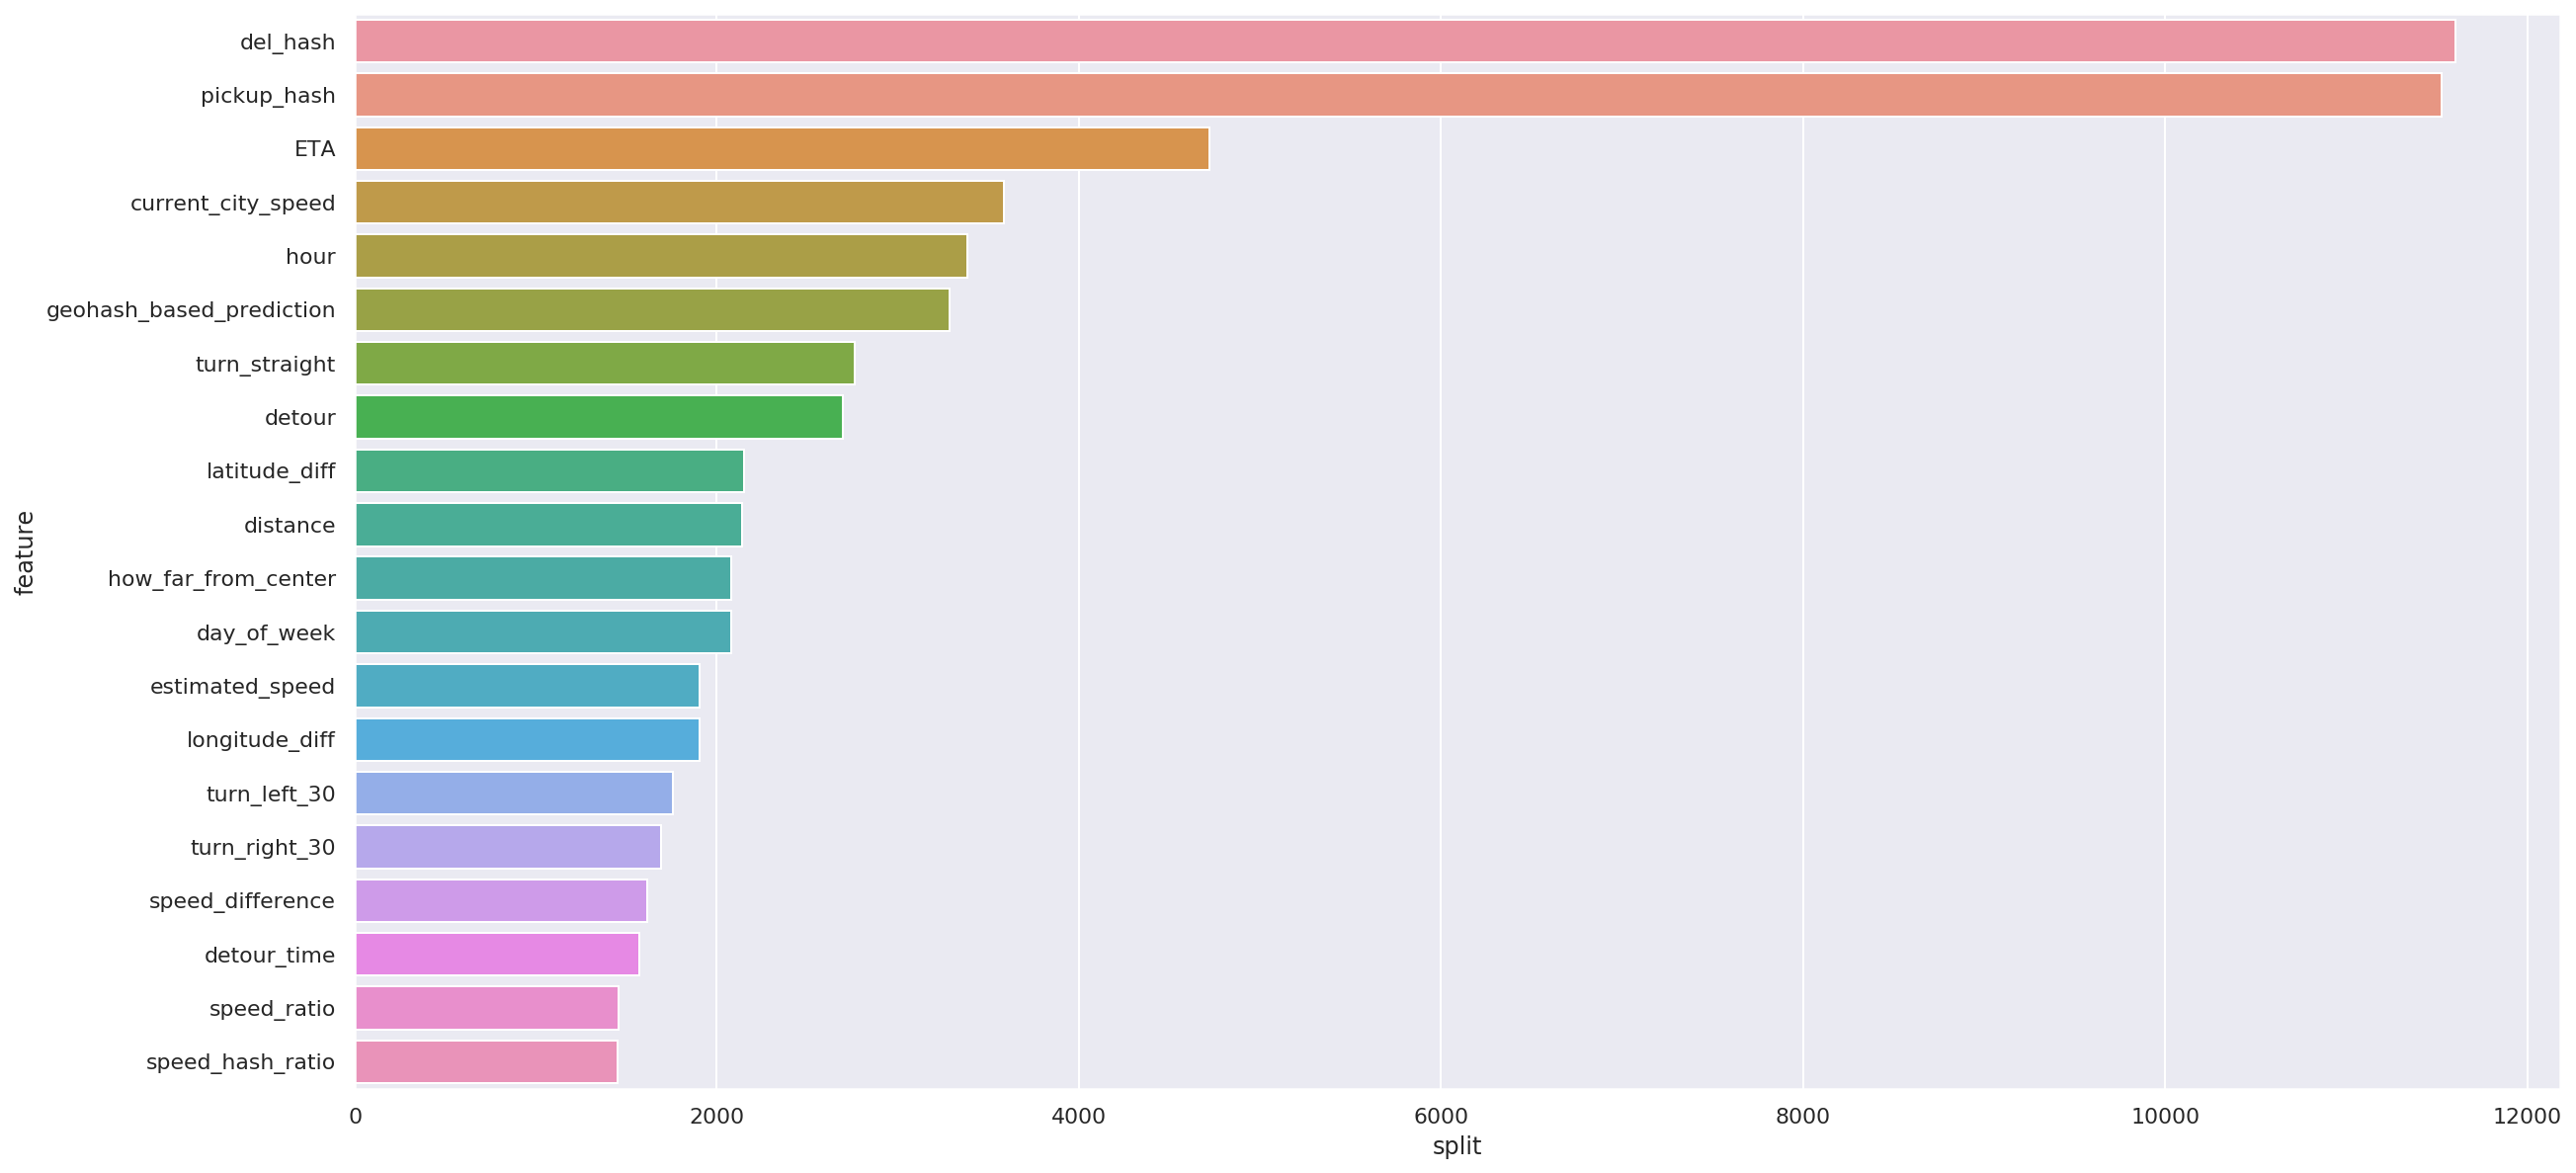

In [23]:
plot_importance(clf.booster_, importance_type='split')

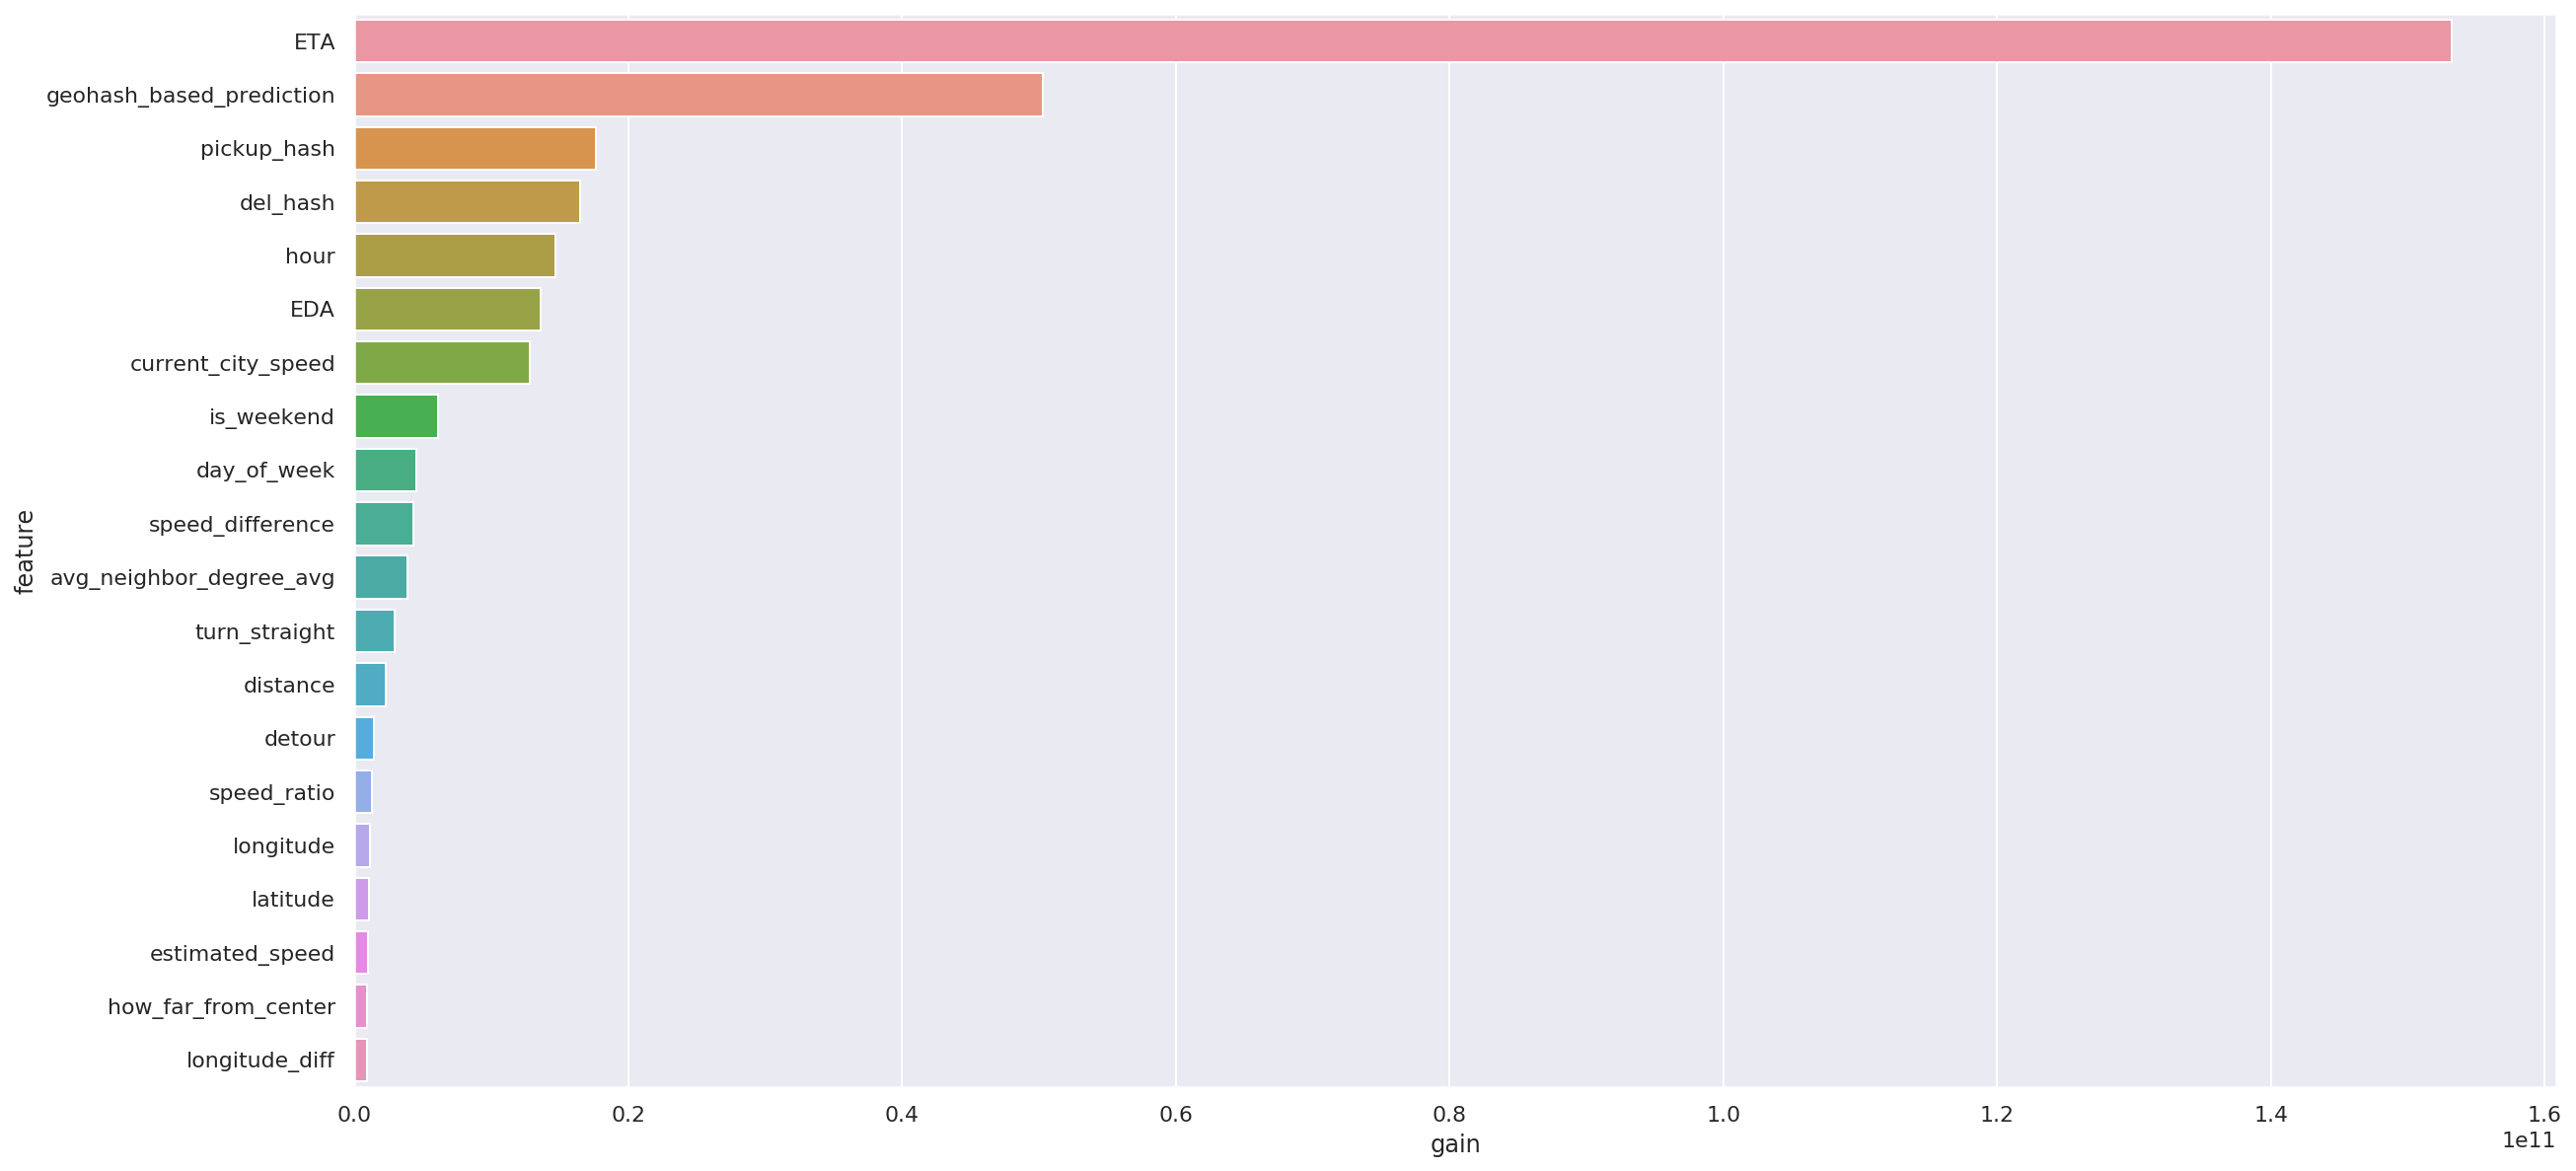

In [24]:
plot_importance(clf.booster_, importance_type='gain')

Опционально можно построить важности признаков при помощи [shap](https://github.com/slundberg/shap)

In [25]:
use_shap = True

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


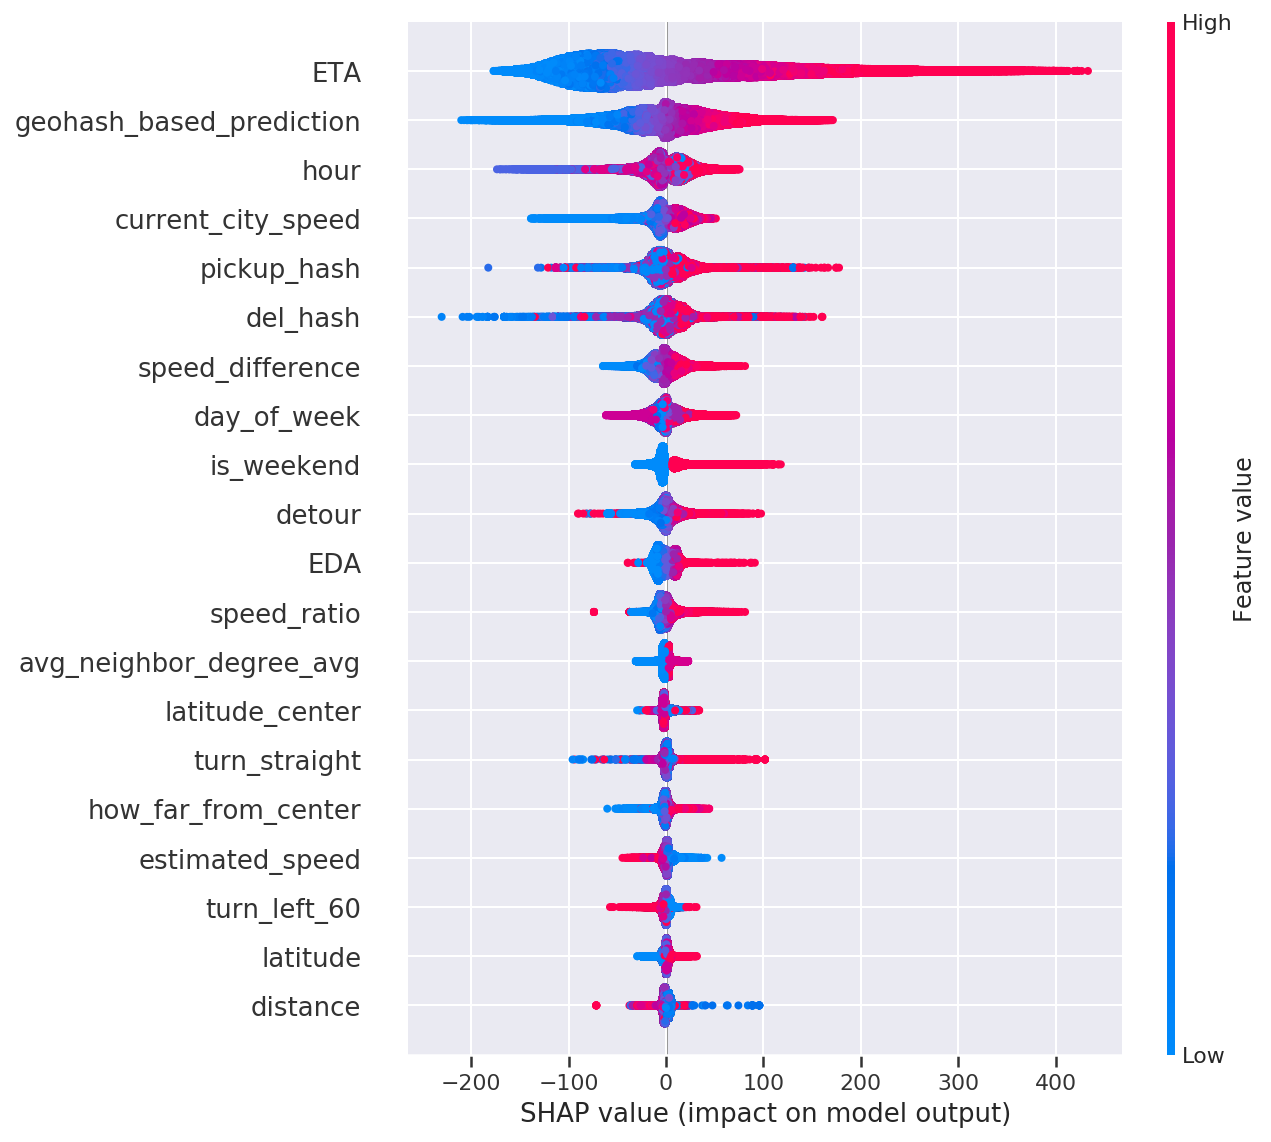

In [26]:
if use_shap:
    import shap 
    shap.initjs()
    shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
    shap.summary_plot(shap_values, X_train)